In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
from scipy import signal
import os
import pytz
import time
import re

/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Parameters

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 43              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

aperture

In [3]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= (7.3)/2)
ap_inner = (ar <= 1.5/2)   
ap = (ap_outer ^ ap_inner).astype(int)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

freq grid

In [4]:
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

Directory Paths

In [5]:
dome_seeing = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_1.35.6_poldm_phase.fits"
clean_seeing = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160229/aored_When_2016.2.29_22.29.18_poldm_phase.fits"
save_path = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Results/temp_power_spec/"
dstr = time.strftime('%Y%m%d')

Process Images

In [7]:
def process_phase(filepath):

    hdulist = fits.open(filepath,memmap=True)
    phase = hdulist[0].data.astype('float')
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 

    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    
    return c_phase

In [11]:
y1_2D = process_phase(dome_seeing)
y2_2D = process_phase(clean_seeing)

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


radial profile

In [8]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

In [9]:
k = radialProfile(kr)

Spatial power spectrum

In [13]:
def sp_power_spec(phase):    
    
    timesteps, phx, phy = phase.shape 
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)
    for t in np.arange(timesteps):
        phFT[t,:,:] = fft.fftshift(fft.fft2(phase[t,:,:]))*2.0/ap.sum()
    print('Done with FT')
    
    # compute 2d psd cube
    psd2D = np.zeros((timesteps, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            psd2D[:,k,l] = np.square(np.abs(phFT[:,k,l]))
    avg_psd2D = np.mean(psd2D, axis=0)
    print('Done with PSD')    
    
    # compute radial average of 2d psd cube and frequency
    avg_psd1D =  radialProfile(avg_psd2D)
    
    return avg_psd1D

In [14]:
y1_psd = sp_power_spec(y1_2D)
y2_psd = sp_power_spec(y2_2D)

Done with FT
Done with PSD
Done with FT
Done with PSD


linear fit

In [35]:
def linear_fit(k,Y):
    
    par = np.polyfit(np.log10(k[(k>.3) & (k<1.)]), np.log10(Y[(k>.3) & (k<1.)]), 1)
    slope = par[0]
    intercept = par[1]
    
    print(slope,intercept)

    return slope,intercept

In [36]:
m1, int1 = linear_fit(k,y1_psd)
m2, int2 = linear_fit(k,y2_psd)

-3.4508511573 -2.63295565071
-3.60911743711 -3.25379711087


<IPython.core.display.Javascript object>


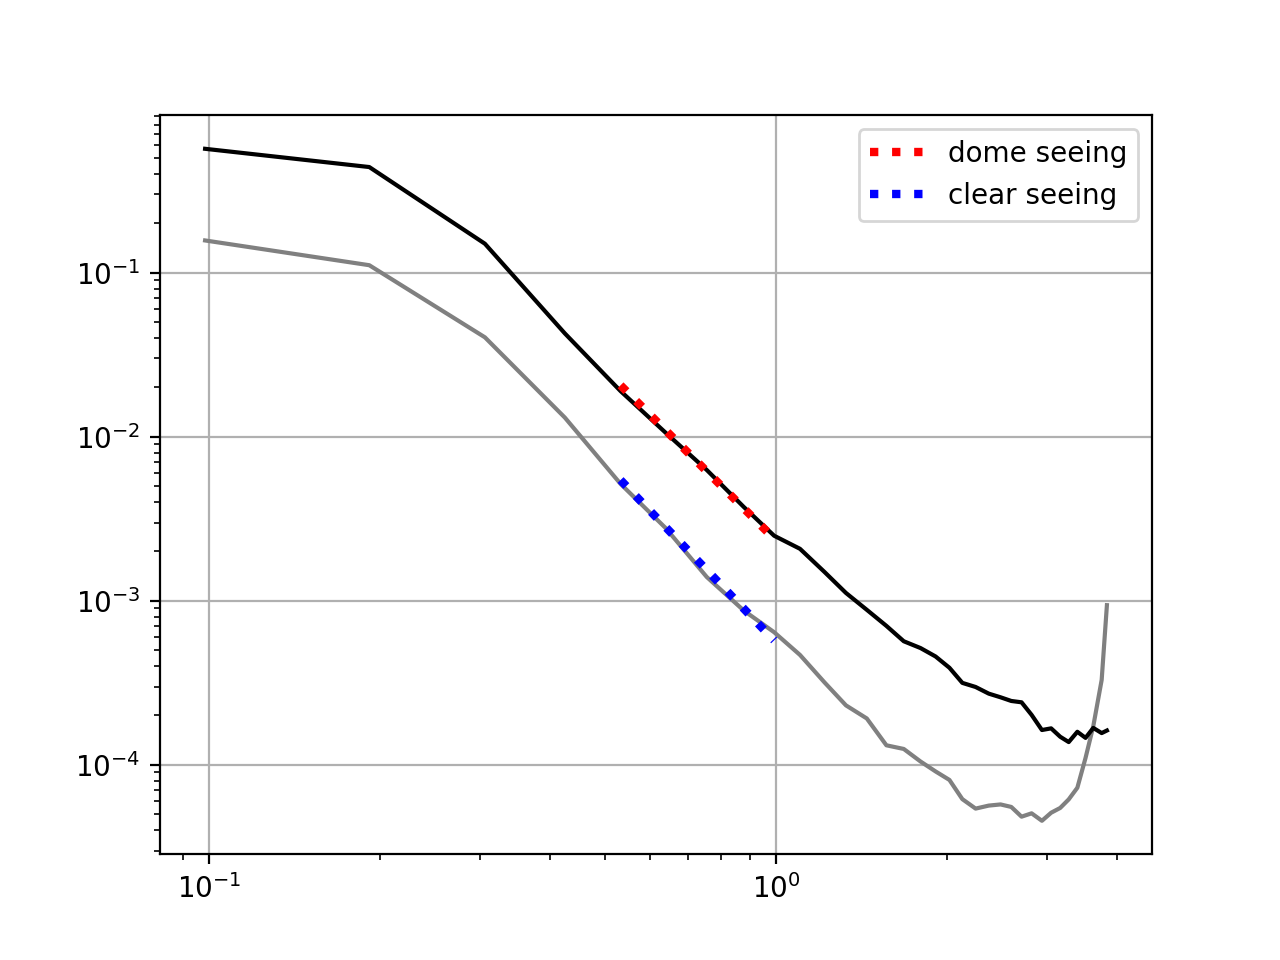

In [41]:
%matplotlib notebook

plt.figure(1)
#plt.loglog(k,P2)

plt.loglog(k,y2_psd,'grey')
plt.loglog(k,y1_psd,'black')

plt.loglog(k[(k>.5) & (k<1.)], (10**int1)*k[(k>.5) & (k<1.)]**m1, 'r:',lw=3, label = 'dome seeing')
plt.loglog(k[(k>.5) & (k<1.)], (10**int2)*k[(k>.5) & (k<1.)]**m2,'b:',lw=3,label = 'clear seeing')

plt.grid(axis='both')
plt.legend()

